In [1]:
import os
import random
import shutil


In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import numpy as np
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()#,
])

In [4]:
train_set = ImageFolder(root='yes_no\\train', transform=transform)
test_set = ImageFolder(root='yes_no\\test', transform=transform)
val_set = ImageFolder(root='yes_no\\val', transform=transform)

# Sprawdzenie etykiet (to jest przypisanie nazw folderów do etykiet)
class_names = train_set.classes
num_labels = len(class_names)
class_names


['no', 'yes']

In [5]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):  # Xavier dla warstw w pełni połączonych i konwolucyjnych
            init.xavier_uniform_(m.weight)  # Lub init.xavier_normal_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)  # Biasy zerujemy


In [6]:

import timm
import torch.nn as nn
model = timm.create_model("deit_tiny_patch16_224")
model.head = nn.Linear(model.head.in_features, 2)  # Resetowanie klasyfikatora
initialize_weights(model)  # Xavier na nowej warstwie

model.patch_embed.proj = nn.Conv2d(1, 192, kernel_size=(16, 16), stride=(16, 16))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [7]:
#model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, 
#                            kernel_size=model.conv_proj.kernel_size, 
#                            stride=model.conv_proj.stride, 
#                            padding=model.conv_proj.padding)
#model.heads.head = nn.Linear(model.heads.head.in_features, 2)
#
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

Dataloading...
Epoch 1, Average Loss: 0.7126, Accuracy: 57.59%, last batch accuracy: 90.00% Time: 0.16s
Epoch 1, Train Accuracy: 57.59%
Epoch 1, Validation Loss: 0.5084, Accuracy: 71.26%
Epoch 2, Average Loss: 0.4793, Accuracy: 77.21%, last batch accuracy: 60.00% Time: 0.09ss
Epoch 2, Train Accuracy: 77.21%
Epoch 2, Validation Loss: 0.6149, Accuracy: 68.16%
Epoch 3, Average Loss: 0.3734, Accuracy: 82.82%, last batch accuracy: 70.00% Time: 0.09ss
Epoch 3, Train Accuracy: 82.82%
Epoch 3, Validation Loss: 0.3005, Accuracy: 85.83%
Epoch 4, Average Loss: 0.2729, Accuracy: 88.00%, last batch accuracy: 80.00% Time: 0.09ss
Epoch 4, Train Accuracy: 88.00%
Epoch 4, Validation Loss: 0.3081, Accuracy: 86.80%
Epoch 5, Average Loss: 0.2112, Accuracy: 91.21%, last batch accuracy: 90.00% Time: 0.09ss
Epoch 5, Train Accuracy: 91.21%
Epoch 5, Validation Loss: 0.2330, Accuracy: 89.32%
Epoch 6, Average Loss: 0.1948, Accuracy: 91.73%, last batch accuracy: 80.00% Time: 0.09ss
Epoch 6, Train Accuracy: 91.73%

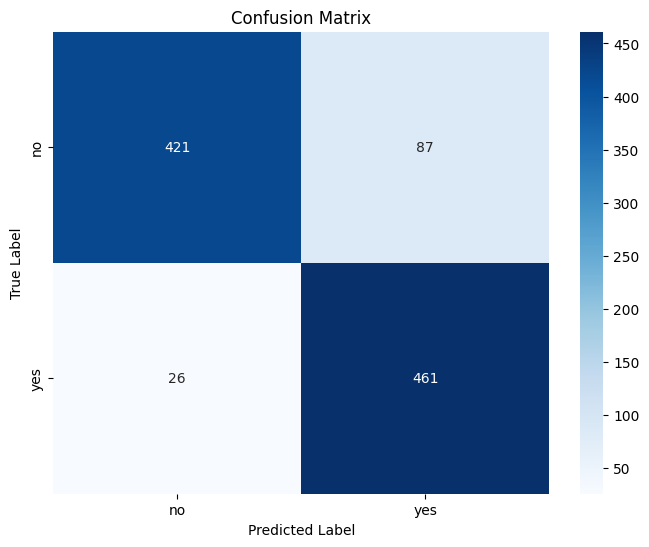

In [8]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet do obliczenia macierzy konfuzji
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Obliczenie macierzy konfuzji
    cm = confusion_matrix(all_labels, all_predictions)
    classes = test_set.classes  # Pobranie nazw klas
    
    # Wizualizacja macierzy konfuzji
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# CNN

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=30):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224 -> 112
        x = self.pool(F.relu(self.conv2(x)))  # 112 -> 56
        x = self.pool(F.relu(self.conv3(x)))  # 56 -> 28
        x = x.view(x.size(0), -1)             # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Dataloading...
Epoch 1, Average Loss: 0.7029, Accuracy: 77.14%, last batch accuracy: 100.00% Time: 0.40s
Epoch 1, Train Accuracy: 77.14%
Epoch 1, Validation Loss: 0.2621, Accuracy: 89.51%
Epoch 2, Average Loss: 0.2817, Accuracy: 88.37%, last batch accuracy: 100.00% Time: 0.02s
Epoch 2, Train Accuracy: 88.37%
Epoch 2, Validation Loss: 0.2249, Accuracy: 92.04%
Epoch 3, Average Loss: 0.2368, Accuracy: 90.87%, last batch accuracy: 100.00% Time: 0.02s
Epoch 3, Train Accuracy: 90.87%
Epoch 3, Validation Loss: 0.2920, Accuracy: 86.60%
Epoch 4, Average Loss: 0.2093, Accuracy: 92.23%, last batch accuracy: 100.00% Time: 0.02s
Epoch 4, Train Accuracy: 92.23%
Epoch 4, Validation Loss: 0.2002, Accuracy: 91.65%
Epoch 5, Average Loss: 0.1921, Accuracy: 92.29%, last batch accuracy: 100.00% Time: 0.02s
Epoch 5, Train Accuracy: 92.29%
Epoch 5, Validation Loss: 0.3098, Accuracy: 85.24%
Epoch 6, Average Loss: 0.1778, Accuracy: 92.94%, last batch accuracy: 80.00% Time: 0.02ss
Epoch 6, Train Accuracy: 92.94

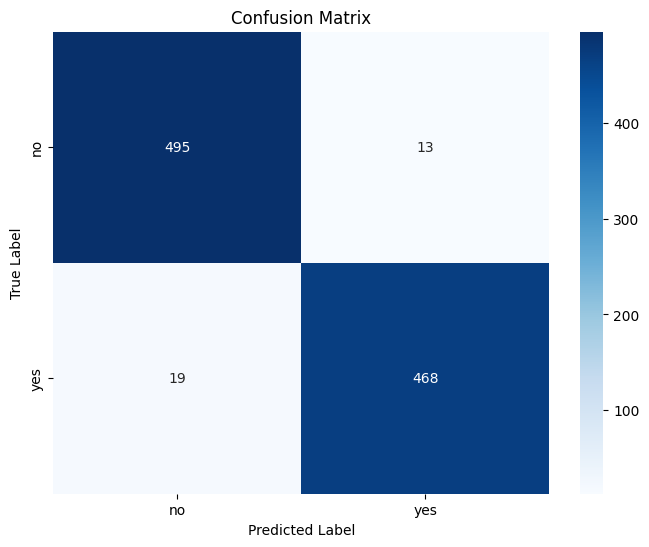

In [10]:

import time
model = SimpleCNN()
initialize_weights(model)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet do obliczenia macierzy konfuzji
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Obliczenie macierzy konfuzji
    cm = confusion_matrix(all_labels, all_predictions)
    classes = test_set.classes  # Pobranie nazw klas
    
    # Wizualizacja macierzy konfuzji
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Vit_16_b

In [13]:
from torchvision.models import vit_b_16
model = vit_b_16()

In [15]:
model.conv_proj = nn.Conv2d(1, model.conv_proj.out_channels, 
                            kernel_size=model.conv_proj.kernel_size, 
                            stride=model.conv_proj.stride, 
                            padding=model.conv_proj.padding)
model.heads.head = nn.Linear(model.heads.head.in_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initialize_weights(model)
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [16]:

import time

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Jeśli używasz CUDA, ustaw również seed dla GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Dla wszystkich urządzeń CUDA
    torch.backends.cudnn.deterministic = True  # Zapewnia deterministyczność
    torch.backends.cudnn.benchmark = True

print('Dataloading...')
data_loader = DataLoader(train_set, batch_size=16, num_workers=6, generator=torch.Generator(device='cpu'),pin_memory=True, shuffle=True,persistent_workers=True, prefetch_factor=4)
data_loader_val =  DataLoader(val_set, batch_size=16, num_workers=4, generator=torch.Generator(device='cpu'), persistent_workers=True, prefetch_factor=2)

#data_loader_val = DataLoader(val_set, batch_size=16, num_workers=2,persistent_workers=True, generator=torch.Generator(device='cpu'))

# Accessing the model configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

previous_time = time.time()
for epoch in range(20):  # Liczba epok
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    previous_time = time.time()
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = batch_X.to(device, non_blocking=True)  # <-- Przesyłanie X na odpowiednie urządzenie
        Y = batch_Y.to(device, non_blocking=True)  # <-- Przesyłanie Y na odpowiednie urządzenie
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()     
        optimizer.step()


        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == Y).sum().item()
        total += Y.size(0)
        
        print(f"Epoch {epoch + 1}, i: {i}, Loss: {total_loss / (i+1):.4f}, Accuracy: {correct / total * 100:.2f}%, last batch accuracy: {(predicted == Y).sum().item()/Y.size(0) * 100:.2f}% Time: {time.time() - previous_time:.2f}s", end='\r')
        previous_time = time.time()

    # Obliczenie średniego straty na epokę
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")
    train_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_Y in data_loader_val:
            X = batch_X.to(device, non_blocking=True)
            Y = batch_Y.to(device, non_blocking=True)
            outputs = model(X)
            loss = criterion(outputs, Y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y).sum().item()
            total += Y.size(0)
    avg_val_loss = val_loss / len(data_loader_val)
    val_accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# 6. Ewaluacja
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():  # Wyłączenie śledzenia gradientów
    data_loader_test = DataLoader(test_set, batch_size=16, num_workers=2, persistent_workers=True, generator=torch.Generator(device='cpu'))
    total = 0
    correct = 0
    for images, labels in data_loader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Zbieranie predykcji i prawdziwych etykiet do obliczenia macierzy konfuzji
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Obliczenie macierzy konfuzji
    cm = confusion_matrix(all_labels, all_predictions)
    classes = test_set.classes  # Pobranie nazw klas
    
    # Wizualizacja macierzy konfuzji
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Dataloading...
Epoch 1, Average Loss: 0.8178, Accuracy: 60.33%, last batch accuracy: 90.00% Time: 1.18s
Epoch 1, Train Accuracy: 60.33%
Epoch 1, Validation Loss: 0.5206, Accuracy: 73.59%



KeyboardInterrupt

